# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [24]:
# import nltk library and models
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download(['punkt','wordnet','stopwords', 'omw-1.4'])
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\omw-1.4.zip.


True

In [32]:
# import libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)

import joblib
import sys
import os
import re
from sqlalchemy import create_engine
import pickle

from scipy.stats import gmean
# import relevant functions/modules from the sklearn
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.metrics import fbeta_score, make_scorer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.base import BaseEstimator,TransformerMixin

%matplotlib inline

In [5]:
# load data from database
database_filepath = "../data/etl_pipeline_preparation.db"
engine = create_engine('sqlite:///' + database_filepath)
table_name = os.path.basename(database_filepath).replace(".db","") + "_table"
df = pd.read_sql_table(table_name,engine)

In [6]:
display(df.head())
display(df.shape)
display(df.describe())

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


(26216, 40)

,id,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
count,26216.00000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.0,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000
mean,15224.82133,0.773650,0.170659,0.004501,0.414251,0.079493,0.050084,0.027617,0.017966,0.032804,0.0,0.063778,0.111497,0.088267,0.015449,0.023039,0.011367,0.033377,0.045545,0.131446,0.065037,0.045812,0.050847,0.020293,0.006065,0.010795,0.004577,0.011787,0.043904,0.278341,0.082202,0.093187,0.010757,0.093645,0.020217,0.052487,0.193584
std,8826.88914,0.435276,0.376218,0.066940,0.492602,0.270513,0.218122,0.163875,0.132831,0.178128,0.0,0.244361,0.314752,0.283688,0.123331,0.150031,0.106011,0.179621,0.208500,0.337894,0.246595,0.209081,0.219689,0.141003,0.077643,0.103338,0.067502,0.107927,0.204887,0.448191,0.274677,0.290700,0.103158,0.291340,0.140743,0.223011,0.395114
min,2.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7446.75000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15662.50000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,22924.25000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,30265.00000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'related'}>,
        <AxesSubplot:title={'center':'request'}>,
        <AxesSubplot:title={'center':'offer'}>,
        <AxesSubplot:title={'center':'aid_related'}>,
        <AxesSubplot:title={'center':'medical_help'}>],
       [<AxesSubplot:title={'center':'medical_products'}>,
        <AxesSubplot:title={'center':'search_and_rescue'}>,
        <AxesSubplot:title={'center':'security'}>,
        <AxesSubplot:title={'center':'military'}>,
        <AxesSubplot:title={'center':'child_alone'}>,
        <AxesSubplot:title={'center':'water'}>],
       [<AxesSubplot:title={'center':'food'}>,
        <AxesSubplot:title={'center':'shelter'}>,
        <AxesSubplot:title={'center':'clothing'}>,
        <AxesSubplot:title={'center':'money'}>,
        <AxesSubplot:title={'center':'missing_people'}>,
        <AxesSubplot:title={'center':'refugees'}>],
       [<AxesSubplot:title={'center':'death'}>,
        <AxesSubplot

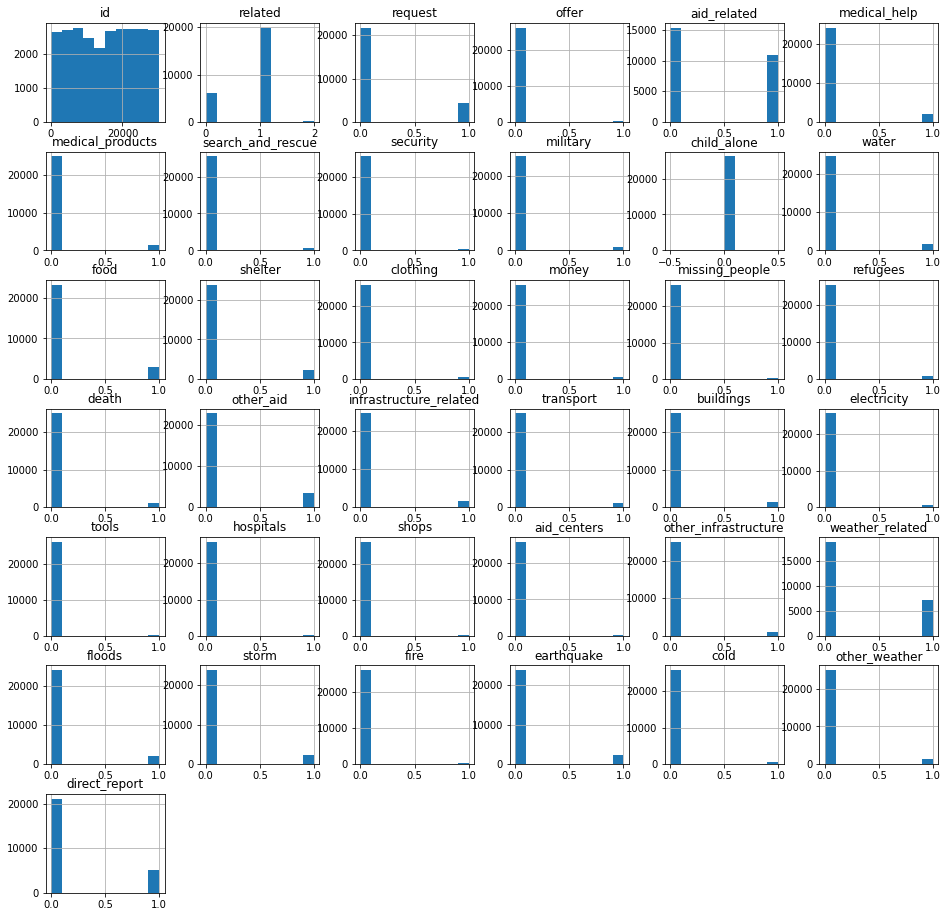

In [7]:
%matplotlib inline
df.hist(figsize =(16,16))

**We see that we have `child_alone` all values 0 and everything else is normalized to 0 or 1 except `related` column** 

In [8]:
df.dtypes

id                         int64
message                   object
original                  object
genre                     object
related                    int64
request                    int64
offer                      int64
aid_related                int64
medical_help               int64
medical_products           int64
search_and_rescue          int64
security                   int64
military                   int64
child_alone                int64
water                      int64
food                       int64
shelter                    int64
clothing                   int64
money                      int64
missing_people             int64
refugees                   int64
death                      int64
other_aid                  int64
infrastructure_related     int64
transport                  int64
buildings                  int64
electricity                int64
tools                      int64
hospitals                  int64
shops                      int64
aid_center

In [9]:
df.isnull().sum()

id                            0
message                       0
original                  16046
genre                         0
related                       0
request                       0
offer                         0
aid_related                   0
medical_help                  0
medical_products              0
search_and_rescue             0
security                      0
military                      0
child_alone                   0
water                         0
food                          0
shelter                       0
clothing                      0
money                         0
missing_people                0
refugees                      0
death                         0
other_aid                     0
infrastructure_related        0
transport                     0
buildings                     0
electricity                   0
tools                         0
hospitals                     0
shops                         0
aid_centers                   0
other_in

In [10]:
display (df[['genre','message','original']].head(10))
display (df['genre'].unique())

,genre,message,original
0,direct,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...
1,direct,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini
2,direct,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ..."
3,direct,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...
4,direct,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...
5,direct,Information about the National Palace-,Informtion au nivaux palais nationl
6,direct,Storm at sacred heart of jesus,Cyclone Coeur sacr de jesus
7,direct,"Please, we need tents and water. We are in Sil...",Tanpri nou bezwen tant avek dlo nou zon silo m...
8,direct,"I would like to receive the messages, thank you",Mwen ta renmen jouin messag yo. Merci
9,direct,I am in Croix-des-Bouquets. We have health iss...,"Nou kwadebouke, nou gen pwoblem sant m yo nan ..."


array(['direct', 'social', 'news'], dtype=object)

In [11]:
df.child_alone.unique()

array([0], dtype=int64)

In [12]:
# dropping child alone because all of the values are 0
new_df = df.drop('child_alone', axis=1)
new_df.shape

(26216, 39)

In [13]:
display(new_df.groupby("related").count())
display(188/new_df.shape[0]*100)

,id,message,original,genre,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
related,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,6122,6122,3395,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122,6122
1,19906,19906,6643,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906,19906
2,188,188,132,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188,188


0.7171193164479707

In [14]:
new_df.related.value_counts()

1    19906
0     6122
2      188
Name: related, dtype: int64

**Since the number is negligible 0.72% of the total rows having `related` == 2 then we will change them to the majority class 1** 

In [15]:
new_df['related']=new_df['related'].apply(lambda x: 1 if x == 2 else x)

**Getting dummies for the categorical variables and removing the first dummy to handling multi-collineatrity**

In [16]:
ohe_df = pd.get_dummies(new_df[['genre']], drop_first=True)
display(ohe_df.shape)
display(ohe_df.sample(10))

(26216, 2)

,genre_news,genre_social
6469,0,0
18403,1,0
10735,0,0
10494,0,1
8956,0,0
14730,1,0
4206,0,0
3029,0,0
11871,0,1
7423,0,0


In [17]:
final_df = pd.concat([new_df,ohe_df], axis=1, sort=False)
display(final_df.shape)
display(final_df.sample(10))

(26216, 41)

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report,genre_news,genre_social
11518,13269,hilgood Not bad really. Earth has been really ...,None,social,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1
21739,25232,"The programme intended, among other things, to...",None,news,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
18657,21823,Substantial contributions from developed count...,None,news,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1122,1346,I am a 35 year old young haitian who witness t...,Mwe se you jan ayisien aje de35 an kidonk vi a...,direct,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0
10887,12515,Putting a blanket & pillow in my car too . Als...,None,social,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
18336,21463,The government is planning to help farmers rep...,None,news,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3447,3965,Please help me. I have needs.,Edem silvouple mwen gen nesesite,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
22769,26376,UNHCR and its partners have made considerably ...,None,news,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
7433,8375,"Help me to find a job please, I am a driver",Fk nou voye yon dyob ban mwen kom chof,direct,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2222,2558,"food, we have no water. We are in the streets ...",manje nou pa gen dlo se nan lari nou ye nou ge...,direct,1,1,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [18]:
final_df.describe()

,id,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report,genre_news,genre_social
count,26216.00000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000
mean,15224.82133,0.766478,0.170659,0.004501,0.414251,0.079493,0.050084,0.027617,0.017966,0.032804,0.063778,0.111497,0.088267,0.015449,0.023039,0.011367,0.033377,0.045545,0.131446,0.065037,0.045812,0.050847,0.020293,0.006065,0.010795,0.004577,0.011787,0.043904,0.278341,0.082202,0.093187,0.010757,0.093645,0.020217,0.052487,0.193584,0.497940,0.091395
std,8826.88914,0.423079,0.376218,0.066940,0.492602,0.270513,0.218122,0.163875,0.132831,0.178128,0.244361,0.314752,0.283688,0.123331,0.150031,0.106011,0.179621,0.208500,0.337894,0.246595,0.209081,0.219689,0.141003,0.077643,0.103338,0.067502,0.107927,0.204887,0.448191,0.274677,0.290700,0.103158,0.291340,0.140743,0.223011,0.395114,0.500005,0.288175
min,2.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7446.75000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15662.50000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,22924.25000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,30265.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 2. Write a tokenization function to process your text data

In [25]:
def tokenize(text):
    # normalize case and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    # tokenize text
    tokens = word_tokenize(text)
    
    # removing stopwords
    tokens = [w for w in tokens if w not in stopwords.words("english")]
    # lemmatize and remove stop words
    lemmatizer = nltk.WordNetLemmatizer()
#     tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords.words("english")]
    clean_tokens = [lemmatizer.lemmatize(w).lower().strip() for w in tokens]
    return clean_tokens

In [26]:
clean_token = tokenize(final_df['message'][0])
print(clean_token)

['weather', 'update', 'cold', 'front', 'cuba', 'could', 'pas', 'haiti']


### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [27]:
import numpy as np
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
X, y = make_multilabel_classification(n_classes=3, random_state=0)

display(X.shape)
display(y.shape)

clf = MultiOutputClassifier(LogisticRegression()).fit(X, y)
clf.predict(X[-2:])

(100, 20)

(100, 3)

array([[1, 1, 1],
       [1, 0, 1]])

In [28]:
# Extract X and y variables from the data for the modelling
X = final_df['message']
y = final_df.iloc[:,4:]
y.shape

(26216, 37)

In [55]:
y.head()

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report,genre_news,genre_social
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
pipeline1 = Pipeline(steps=[
        ('count_vectorizer', CountVectorizer(tokenizer=tokenize)),
        ('tfidf_transformer', TfidfTransformer()),
        ('clf', MultiOutputClassifier(RandomForestClassifier(verbose=True)))
    ])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [30]:
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state = 1)

In [31]:
pipeline1_fitted = pipeline1.fit(train_X, train_y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   23.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   17.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   24.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   10.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

**Pipeline 1 - Random Forest**

In [59]:
y_prediction_test_1 = pipeline1_fitted.predict(val_X)
print(classification_report(val_y.iloc[:, 1:].values, np.array([x[1:] for x in y_prediction_test_1])))

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]

             precision    recall  f1-score   support

          0       0.79      0.45      0.57       919
          1       0.00      0.00      0.00        23
          2       0.75      0.60      0.67      2189
          3       0.67      0.12      0.20       447
          4       0.81      0.06      0.11       276
          5       0.46      0.05      0.08       133
          6       0.00      0.00      0.00        84
          7       0.52      0.09      0.15       152
          8       0.87      0.38      0.53       336
          9       0.84      0.47      0.60       604
         10       0.81      0.30      0.44       454
         11       0.81      0.27      0.40        78
         12       0.67      0.02      0.03       112
         13       1.00      0.03      0.06        64
         14       0.38      0.02      0.03       166
         15       0.60      0.12      0.20       221
         16       0.48      0.05      0.10       704
         17       0.44      0.01      0.02   

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [71]:
accuracy_score(val_y.iloc[:, 1:].values, np.array([x[1:] for x in y_prediction_test_1]))

0.35373760488176964

In [27]:
# accuracy_lst_pipeline1 = []
# # Calculate the accuracy for each of them.
# for i in range(len(y.columns.values)):
#     print(f'Category {i}: {y.columns.values[i]} ')
#     print(classification_report(val_y.iloc[:, i].values, y_prediction_test_1[:, i]))
#     acc = accuracy_score(val_y.iloc[:, i].values, y_prediction_test_1[:, i])
#     print(f'Accuracy {acc}\n\n')
#     accuracy_lst_pipeline1.append(acc)

In [28]:
# sum(accuracy_lst_pipelin1)/len(accuracy_lst_pipelin1)

### 6. Improve your model
Use grid search to find better parameters. 

In [65]:
parameters = {'count_vectorizer__min_df': [1], #, 5],
              'tfidf_transformer__use_idf':[True, False],
              'clf__estimator__n_estimators':[10], #, 25], 
              'clf__estimator__min_samples_split':[5, 10]} #2,

pipeline1_cv = GridSearchCV(pipeline1, param_grid = parameters, scoring='accuracy')


In [66]:
# fit the grid search cv pipeline
GS_model = pipeline1_cv.fit(train_X, train_y)

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]

In [67]:
GS_model.cv_results_

/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py

{'mean_fit_time': array([ 92.04389373,  92.21700772,  88.88382037,  88.40462025]),
 'std_fit_time': array([ 0.5735075 ,  0.53541121,  0.40265224,  0.4020891 ]),
 'mean_score_time': array([ 32.58305661,  32.62283603,  32.7898399 ,  32.76609198]),
 'std_score_time': array([ 0.31206958,  0.21107126,  0.08648366,  0.29578579]),
 'param_clf__estimator__min_samples_split': masked_array(data = [5 5 10 10],
              mask = [False False False False],
        fill_value = ?),
 'param_clf__estimator__n_estimators': masked_array(data = [10 10 10 10],
              mask = [False False False False],
        fill_value = ?),
 'param_count_vectorizer__min_df': masked_array(data = [1 1 1 1],
              mask = [False False False False],
        fill_value = ?),
 'param_tfidf_transformer__use_idf': masked_array(data = [True False True False],
              mask = [False False False False],
        fill_value = ?),
 'params': [{'clf__estimator__min_samples_split': 5,
   'clf__estimator__n_estimato

In [68]:
# Finding the best parameters
GS_model.best_params_

{'clf__estimator__min_samples_split': 5,
 'clf__estimator__n_estimators': 10,
 'count_vectorizer__min_df': 1,
 'tfidf_transformer__use_idf': False}

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [69]:
y_prediction_test_gs = GS_model.predict(val_X)
print(classification_report(val_y.iloc[:, 1:].values, np.array([x[1:] for x in y_prediction_test_gs])))

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]

             precision    recall  f1-score   support

          0       0.79      0.50      0.61       919
          1       0.00      0.00      0.00        23
          2       0.73      0.68      0.70      2189
          3       0.53      0.11      0.18       447
          4       0.74      0.09      0.16       276
          5       0.62      0.06      0.11       133
          6       0.00      0.00      0.00        84
          7       0.58      0.14      0.23       152
          8       0.82      0.47      0.60       336
          9       0.84      0.49      0.62       604
         10       0.78      0.39      0.52       454
         11       0.70      0.09      0.16        78
         12       0.25      0.01      0.02       112
         13       1.00      0.08      0.14        64
         14       0.40      0.04      0.07       166
         15       0.79      0.25      0.38       221
         16       0.39      0.04      0.07       704
         17       0.40      0.01      0.01   

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [70]:
accuracy_score(val_y.iloc[:, 1:].values, np.array([x[1:] for x in y_prediction_test_gs]))

0.34229595728451562

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

**Trying another ML aldorithm**

In [ ]:
from sklearn.svm import SVC
pipeline2 = Pipeline([
    ('vect', CountVectorizer(tokenizer = tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(SVC()))
])

parameters2 = {'vect__min_df': [5],
              'tfidf__use_idf':[True],
              'clf__estimator__kernel': ['poly'], 
              'clf__estimator__degree': [1, 2, 3],
              'clf__estimator__C':[1, 10, 100]}

pipeline2_cv = GridSearchCV(pipeline2, param_grid = parameters2, scoring = 'accuracy', verbose = 10)

# Find best parameters
GS_model2 = pipeline2_cv.fit(train_X, train_y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] clf__estimator__C=1, clf__estimator__degree=1, clf__estimator__kernel=poly, tfidf__use_idf=True, vect__min_df=5 
[CV]  clf__estimator__C=1, clf__estimator__degree=1, clf__estimator__kernel=poly, tfidf__use_idf=True, vect__min_df=5, score=0.11457588327850093, total= 5.7min
[CV] clf__estimator__C=1, clf__estimator__degree=1, clf__estimator__kernel=poly, tfidf__use_idf=True, vect__min_df=5 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.2min remaining:    0.0s


[CV]  clf__estimator__C=1, clf__estimator__degree=1, clf__estimator__kernel=poly, tfidf__use_idf=True, vect__min_df=5, score=0.08210556429695323, total= 5.6min
[CV] clf__estimator__C=1, clf__estimator__degree=1, clf__estimator__kernel=poly, tfidf__use_idf=True, vect__min_df=5 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 18.4min remaining:    0.0s


[CV]  clf__estimator__C=1, clf__estimator__degree=1, clf__estimator__kernel=poly, tfidf__use_idf=True, vect__min_df=5, score=0.10529327610872675, total= 5.6min
[CV] clf__estimator__C=1, clf__estimator__degree=2, clf__estimator__kernel=poly, tfidf__use_idf=True, vect__min_df=5 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 27.6min remaining:    0.0s


[CV]  clf__estimator__C=1, clf__estimator__degree=2, clf__estimator__kernel=poly, tfidf__use_idf=True, vect__min_df=5, score=0.11457588327850093, total= 5.6min
[CV] clf__estimator__C=1, clf__estimator__degree=2, clf__estimator__kernel=poly, tfidf__use_idf=True, vect__min_df=5 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 36.7min remaining:    0.0s


[CV]  clf__estimator__C=1, clf__estimator__degree=2, clf__estimator__kernel=poly, tfidf__use_idf=True, vect__min_df=5, score=0.08210556429695323, total= 5.6min
[CV] clf__estimator__C=1, clf__estimator__degree=2, clf__estimator__kernel=poly, tfidf__use_idf=True, vect__min_df=5 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 45.7min remaining:    0.0s


In [ ]:
# grid search results
GS_model2.cv_results_

In [ ]:
GS_model2.best_params_

In [ ]:
y_prediction_test_gs2 = GS_model2.predict(val_X)
print(classification_report(val_y.iloc[:, 1:].values, np.array([x[1:] for x in y_prediction_test_gs2])))

In [ ]:
accuracy_score(val_y.iloc[:, 1:].values, np.array([x[1:] for x in y_prediction_test_gs2]))

In [ ]:
# y_prediction_test_2 = pipeline2_fitted.predict(val_X)

# print(classification_report(val_y.iloc[:, 1:].values, np.array([x[1:] for x in y_prediction_test_2])))

# accuracy_lst_pipeline2 = []
# # Calculate the accuracy for each of them.
# for i in range(len(y.columns.values)):
#     print(f'Category {i}: {y.columns.values[i]} ')
#     print(classification_report(val_y.iloc[:, i].values, y_prediction_test_2[:, i]))
#     acc = accuracy_score(val_y.iloc[:, i].values, y_prediction_test_2[:, i])
#     print(f'Accuracy {acc}\n\n')
#     accuracy_lst_pipeliene2.append(acc)

# sum(accuracy_lst_pipelin2)/len(accuracy_lst_pipelin2)

### 9. Export your model as a pickle file

In [33]:
joblib.dump(pipeline1_fitted, '../models/ML_Disaster_notebook_model.pkl')

['../model/ML_Disaster_notebook_model.pkl']

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.